# Analysis & Visualization
Derive multi-level OFI metrics (up to 5 levels) for each stock in the dataset. Integrate these multi-level OFIs into a single metric using Principal Component Analysis (PCA) or another dimensionality reduction method. 

Examine the contemporaneous cross-impact of OFI on short-term price changes across stocks. Evaluate the predictive power of lagged cross-asset OFI on future price changes (e.g., 1-minute and 5-minute horizons). Use regression models to assess the explanatory power of contemporaneous OFI and predictive power of lagged OFI. 

Compare self-impact (within the same stock) vs. cross-impact (between stocks) in the models. Include clear and informative table, heatmap, scatter plot, line graph for OFI metrics for individual stocks and cross-impact relationships between stocks.

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from typing import Dict, Tuple

In [3]:
def compute_order_flow(book_updates: pd.DataFrame, levels: int) -> Tuple[Dict[int, pd.Series], Dict[int, pd.Series]]:
    """
    Compute bid and ask order flows at each level of the order book.
    
    Parameters
    ----------
        book_updates: pd.DataFrame
            DataFrame containing order book updates with columns for bid and ask prices/sizes.
        levels: int
            Number of levels in the order book to consider.

    Returns
    ----------
        Tuple[Dict[int, pd.Series], Dict[int, pd.Series]]
            Dictionaries containing bid and ask order flows for each level.
    """
    of_bid = {}
    of_ask = {}
    for level in range(1, levels + 1):
        of_bid[level] = book_updates[f'bid_sz_{level:02d}'].diff().fillna(0)
        of_ask[level] = -book_updates[f'ask_sz_{level:02d}'].diff().fillna(0)

        of_bid[level][book_updates[f'bid_px_{level:02d}'].diff() < 0] = 0
        of_ask[level][book_updates[f'ask_px_{level:02d}'].diff() > 0] = 0
    return of_bid, of_ask

def compute_best_level_ofi(of_bid, of_ask):
    best_ofi = of_bid[1] - of_ask[1]
    return best_ofi.cumsum()

def compute_deeper_level_ofi(of_bid: Dict[int, pd.Series], of_ask: Dict[int, pd.Series], levels: int) -> Dict[int, pd.Series]:
    """
    Compute the deeper-level Order Flow Imbalance (OFI) for each level.
    
    Parameters
    ----------
        of_bid: (Dict[int, pd.Series])
            Bid order flows for each level.
        of_ask: (Dict[int, pd.Series])
            Ask order flows for each level.
        levels: int
            Number of levels in the order book to consider.

    Returns
    ----------
        Dict[int, pd.Series]
            Cumulative deeper-level OFI for each level over time.
    """
    deeper_ofi = {}
    for level in range(1, levels + 1):
        deeper_ofi[level] = (of_bid[level] - of_ask[level]).cumsum()
    return deeper_ofi

def compute_multi_level_ofi(deeper_ofi: Dict[int, pd.Series], levels: int) -> np.ndarray:
    """
    Compute the multi-level OFI vector by stacking deeper-level OFIs for all levels.
    
    Parameters
    ----------
        deeper_ofi: Dict[int, pd.Series]
            Cumulative deeper-level OFI for each level.
        levels: int
            Number of levels in the order book to consider.

    Returns
    ----------
        np.ndarray: Multi-level OFI vector (time series) with shape (n_samples, levels).
    """
    multi_level_ofi = np.vstack([deeper_ofi[level] for level in range(1, levels + 1)]).T
    return multi_level_ofi

def compute_average_depth(book_updates: pd.DataFrame, levels: int) -> np.ndarray:
    """
    Compute the average order book depth used to scale the OFI.
    
    Parameters
    ----------
        book_updates: pd.DataFrame
            DataFrame containing order book updates with size columns for bid and ask sides.
        levels: int
            Number of levels in the order book to consider.

    Returns
    ----------
        np.ndarray
            Average depth for scaling OFI at each level.
    """
    avg_depths = []
    for level in range(1, levels + 1):
        avg_depth = book_updates[[f'bid_sz_{level:02d}', f'ask_sz_{level:02d}']].mean(axis=1).mean()
        avg_depths.append(avg_depth)
    return np.array(avg_depths)


def scale_ofi(multi_level_ofi: np.ndarray, avg_depths: np.ndarray) -> np.ndarray:
    """
    Scale the multi-level OFI by the average order book depth.
    
    Parameters
    ----------
        multi_level_ofi (np.ndarray): Multi-level OFI vector (time series).
        avg_depths (np.ndarray): Average depth for scaling.

    Returns
    ----------
        np.ndarray: Scaled multi-level OFI vector.
    """
    scaled_ofi = multi_level_ofi / avg_depths
    return scaled_ofi


def calculate_ofi(book_updates: pd.DataFrame, levels: int = 5) -> pd.DataFrame:
    """
    Calculate the multi-level Order Flow Imbalance (OFI).
    
    Parameters
    ----------
        book_updates: pd.DataFrame
            DataFrame containing order book updates with bid/ask sizes and prices.
        levels: int, optional
            Number of levels in the order book to consider. Default is 5.

    Returns
    ----------
        pd.DataFrame
            Scaled multi-level OFI vector.
    """
    of_bid, of_ask = compute_order_flow(book_updates, levels)
    deeper_ofi = compute_deeper_level_ofi(of_bid, of_ask, levels)
    multi_level_ofi = compute_multi_level_ofi(deeper_ofi, levels)
    avg_depths = compute_average_depth(book_updates, levels)
    scaled_ofi = scale_ofi(multi_level_ofi, avg_depths)
    return pd.DataFrame(scaled_ofi)

def cross_impact(ofi_data: pd.DataFrame, price_changes: pd.DataFrame) -> pd.DataFrame:
    """
    Perform contemporaneous cross-impact analysis using regression.
    
    Parameters
    ----------
        ofi_df: pd.DataFrame
            OFI data.
        price_change_df: pd.DataFrame
            Price change data.
    
    Returns
    ----------
        pd.DataFrame
            Coefficients of self-impact and cross-impact for each stock.
    """
    results = {}
    stocks = price_changes.columns

    for target_stock in stocks:
        X = ofi_data.values
        y = price_changes[target_stock].values
        
        model = LinearRegression().fit(X, y)

        results[target_stock] = {
            "coefficients": model.coef_,
            "r_squared": model.score(X, y),
        }
    return results

def plot_cross_impact_heatmap(coefficients):
    """
    Plot a heatmap of cross-impact coefficients.
    
    Parameters
    ----------
        coefficients: pd.DataFrame
            Coefficient matrix of cross-impact.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(coefficients, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Cross-Impact Coefficients (OFI -> Price Change)")
    plt.ylabel("Impacting Stock")
    plt.xlabel("Target Stock")
    plt.show()

def prepare_lagged_data(source_stock, target_stock, lag_intervals, analysis_data_df):
    X = analysis_data_df[[f"pca_ofi_{source_stock}_lag{lag}" for lag in lag_intervals]].dropna()
    y = analysis_data_df[f"price_changes_{target_stock}"].shift(-max(lag_intervals)).dropna()
    valid_indices = X.index.intersection(y.index)
    return X.loc[valid_indices], y.loc[valid_indices]

In [4]:
stocks = ["AAPL", "AMGN", "TSLA", "JPM", "XOM"]
path = "/Users/ibringfaith/Documents/GitHub/cross-impact-analysis-of-order-flow-imbalance/data"
data = {stock: pd.read_csv(f"{path}/{stock}.csv") for stock in stocks}

## Compute OFI Metrics

In [5]:
ofi_data = {stock: calculate_ofi(data[stock]) for stock in stocks}
for stock_name, multi_level_ofi_metrics in ofi_data.items():
    print(f"Multi-level OFI metrics (up to 5 levels) for {stock_name}")
    print(multi_level_ofi_metrics.head())

Multi-level OFI metrics (up to 5 levels) for AAPL
          0        1    2    3    4
0  0.000000  0.00000  0.0  0.0  0.0
1  0.000000  0.00000  0.0  0.0  0.0
2  0.280681  0.00000  0.0  0.0  0.0
3  1.538134  0.00000  0.0  0.0  0.0
4  0.561363  1.18149  0.0  0.0  0.0
Multi-level OFI metrics (up to 5 levels) for AMGN
     0    1    2    3    4
0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0
Multi-level OFI metrics (up to 5 levels) for TSLA
          0         1    2    3    4
0  0.000000  0.000000  0.0  0.0  0.0
1  0.112397  0.000000  0.0  0.0  0.0
2  0.112397  0.000000  0.0  0.0  0.0
3  1.802848  0.117855  0.0  0.0  0.0
4  1.802848  0.117855  0.0  0.0  0.0
Multi-level OFI metrics (up to 5 levels) for JPM
          0    1    2    3    4
0  0.000000  0.0  0.0  0.0  0.0
1  0.000000  0.0  0.0  0.0  0.0
2  4.385618  0.0  0.0  0.0  0.0
3  8.771235  0.0  0.0  0.0  0.0
4  8.771235  0.0  0.0  0.0  0.0
Multi-lev

In [6]:
pca = PCA(n_components=1)
pca_ofi_data = {
    stock: pd.Series(pca.fit_transform(ofi.dropna()).flatten(), name="PCA_OFI")
    for stock, ofi in ofi_data.items()
}

pca_ofi_df = pd.DataFrame(pca_ofi_data).fillna(0)
print("Integrated Multi-level OFI metrics:")
print(pca_ofi_df.head())

Integrated Multi-level OFI metrics:
           AAPL         AMGN           TSLA           JPM           XOM
0  35194.959061  1943.094278  268365.787213  36005.345080  75106.724547
1  35194.959061  1943.094278  268365.840499  36005.345080  75106.724547
2  35195.164280  1943.094278  268365.840499  36008.801500  75106.724547
3  35196.083660  1943.094278  268366.690020  36012.257921  75106.724547
4  35196.028979  1943.094278  268366.690020  36012.257921  75106.724547


## Analyze cross-impact

In [7]:
price_changes = pd.DataFrame({stock: data[stock]["price"].pct_change() for stock in stocks})
price_changes_df = price_changes.fillna(0)
print(price_changes_df.head())

       AAPL      AMGN      TSLA       JPM       XOM
0  0.000000  0.000000  0.000000  0.000000  0.000000
1 -0.025659  0.015525  2.871124  0.026338  0.013458
2 -0.007864 -0.013706 -0.745000 -0.019778 -0.013279
3  0.022074  0.012293  0.026307  0.019861  0.013458
4 -0.000451 -0.000528 -0.012936 -0.018014 -0.013109


In [8]:
print("Shape of integrated multi-level metrics dataframe:", pca_ofi_df.shape)
print("Shape of price changes dataframe:", price_changes_df.shape)

Shape of integrated multi-level metrics dataframe: (17127528, 5)
Shape of price changes dataframe: (17127528, 5)


In [9]:
cross_impact_results = cross_impact(pca_ofi_df, price_changes_df)

In [10]:
for coefficients, r_squared in cross_impact_results.items():
    print(coefficients, r_squared)

AAPL {'coefficients': array([-6.36184872e-11,  1.25348004e-09,  1.12654017e-11,  2.67675069e-11,
        2.05618659e-12]), 'r_squared': 3.945216380252248e-07}
AMGN {'coefficients': array([1.16890038e-05, 1.01332437e-02, 1.56367510e-06, 2.20744507e-04,
       2.41595386e-05]), 'r_squared': 8.950020599418629e-06}
TSLA {'coefficients': array([ 5.34493421e-11,  6.00914213e-09, -5.77899570e-12,  1.16689836e-10,
        5.08944685e-12]), 'r_squared': 2.8517305961095474e-07}
JPM {'coefficients': array([ 2.91484176e-09, -2.21898660e-06,  5.31724221e-10,  3.17569120e-08,
        7.06829579e-09]), 'r_squared': 4.879191349282941e-06}
XOM {'coefficients': array([ 7.55956190e-09, -3.78767773e-08,  1.24793925e-09,  1.12403388e-08,
       -4.55936549e-10]), 'r_squared': 2.5584491436525525e-07}


In [11]:
coeff_matrix = pd.DataFrame(
        {stock: res["coefficients"] for stock, res in cross_impact_results.items()},
        index=stocks
    )

coeff_matrix.index.name = "Impacting Stock"
coeff_matrix.columns.name = "Target Stock"

print(coeff_matrix.head())

Target Stock             AAPL      AMGN          TSLA           JPM  \
Impacting Stock                                                       
AAPL            -6.361849e-11  0.000012  5.344934e-11  2.914842e-09   
AMGN             1.253480e-09  0.010133  6.009142e-09 -2.218987e-06   
TSLA             1.126540e-11  0.000002 -5.778996e-12  5.317242e-10   
JPM              2.676751e-11  0.000221  1.166898e-10  3.175691e-08   
XOM              2.056187e-12  0.000024  5.089447e-12  7.068296e-09   

Target Stock              XOM  
Impacting Stock                
AAPL             7.559562e-09  
AMGN            -3.787678e-08  
TSLA             1.247939e-09  
JPM              1.124034e-08  
XOM             -4.559365e-10  


In [12]:
results_path = "/Users/ibringfaith/Documents/GitHub/cross-impact-analysis-of-order-flow-imbalance/results"
pd.DataFrame(cross_impact_results).to_csv(f"{results_path}/cross_impact_results.csv")

The goal is to determine how the Order Flow Imbalance (OFI) of one stock (source stock) contemporaneously impacts the short-term price change of another stock (target stock).

This can reveal relationships such as lead-lag dynamics where some stocks consistently drive movements in others and market-wide liquidity and demand factors influencing correlated stocks.

The R-squared values measure how much of the variance in the target stock's price change is explained by the source stock's OFI metric. An R-squared value close to 1 indicates strong explanatory power. 

The sign and magnitude of the linear regression coefficients indicate the direction and strength of the impact. Positive coefficients imply that an increase in the source stock's OFI metric leads to a positive price change in the target stock. Negative coefficients imply an inverse relationship.

### Cross-impact relationships between stocks

Identify which stocks are drivers of impact and highlight the sectors with high cross-impact.


Diagonal values (self-impact): High coefficients indicate that a stock's own OFI strongly affects its price changes.

Off-diagonal values (cross-impact): Significant coefficients suggest that the OFI of one stock influences the price change of another stock.

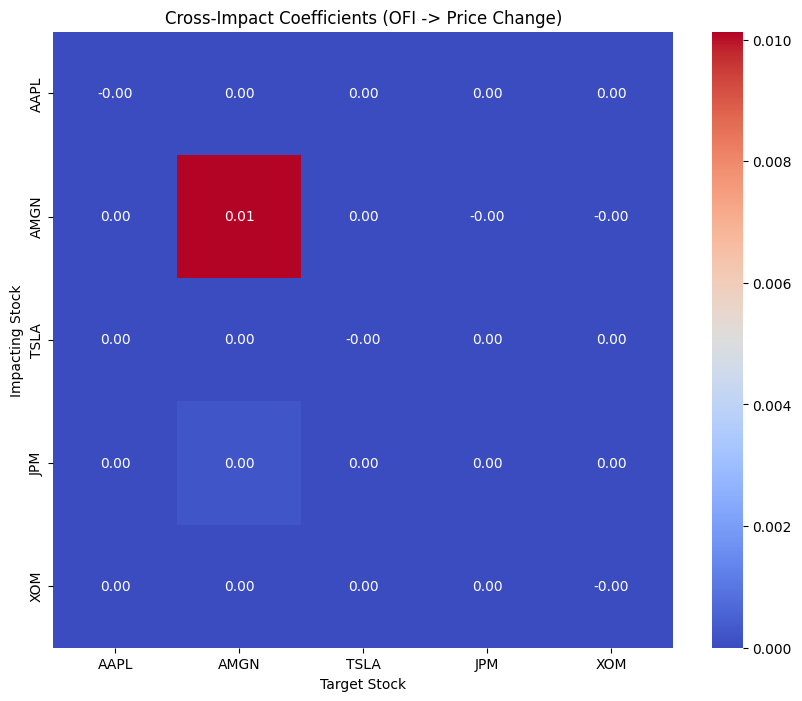

In [12]:
plot_cross_impact_heatmap(coeff_matrix)

Understand linear relationships and identify outliers or nonlinear patterns.

/var/folders/49/z94j8bls1pzc2tkztsbpztm40000gn/T/ipykernel_47687/2211560286.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{results_path}/cross_impact_scatter.png")
/Users/ibringfaith/.pyenv/versions/3.10.14/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


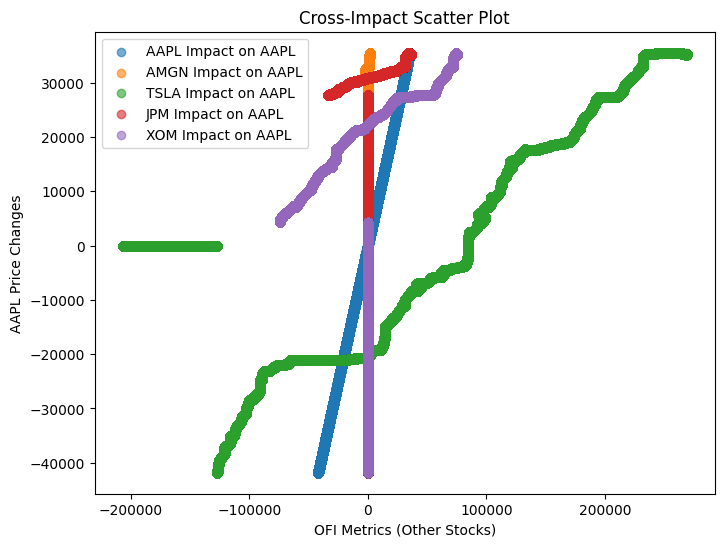

In [13]:
plt.figure(figsize=(8, 6))
for stock in stocks:
    plt.scatter(
        pca_ofi_df[stock],
        pca_ofi_df["AAPL"],
        label=f"{stock} Impact on AAPL",
        alpha=0.6,
    )
plt.title("Cross-Impact Scatter Plot")
plt.xlabel("OFI Metrics (Other Stocks)")
plt.ylabel("AAPL Price Changes")
plt.legend()
plt.savefig(f"{results_path}/cross_impact_scatter.png")
plt.show()

In [13]:
pca_ofi_df_copy = pca_ofi_df.copy()
price_changes_df_copy = price_changes_df.copy()

pca_ofi_df_copy.columns = [f"pca_ofi_{col}" for col in pca_ofi_df.columns]
price_changes_df_copy.columns = [f"price_changes_{col}" for col in price_changes_df.columns]

analysis_data_df = pd.concat([pca_ofi_df_copy, price_changes_df_copy], axis=1)

print(analysis_data_df.head())

   pca_ofi_AAPL  pca_ofi_AMGN   pca_ofi_TSLA   pca_ofi_JPM   pca_ofi_XOM  \
0  35194.959061   1943.094278  268365.787213  36005.345080  75106.724547   
1  35194.959061   1943.094278  268365.840499  36005.345080  75106.724547   
2  35195.164280   1943.094278  268365.840499  36008.801500  75106.724547   
3  35196.083660   1943.094278  268366.690020  36012.257921  75106.724547   
4  35196.028979   1943.094278  268366.690020  36012.257921  75106.724547   

   price_changes_AAPL  price_changes_AMGN  price_changes_TSLA  \
0            0.000000            0.000000            0.000000   
1           -0.025659            0.015525            2.871124   
2           -0.007864           -0.013706           -0.745000   
3            0.022074            0.012293            0.026307   
4           -0.000451           -0.000528           -0.012936   

   price_changes_JPM  price_changes_XOM  
0           0.000000           0.000000  
1           0.026338           0.013458  
2          -0.019778      

In [14]:
contemporaneous_results = {}
coeff_results = {}

for target_stock in stocks:
    contemporaneous_results[target_stock] = {}
    coeff_results[target_stock] = {}
    for source_stock in stocks:
        if source_stock == target_stock:
            continue

        X = analysis_data_df[[f"pca_ofi_{source_stock}"]]
        y = analysis_data_df[f"price_changes_{target_stock}"]

        model = LinearRegression().fit(X, y)

        contemporaneous_results[target_stock][source_stock] = r2_score(y, model.predict(X))
        coeff_results[target_stock][source_stock] = model.coef_[0]


Higher R-squared values indicate stronger contemporaneous cross-impact.

Diagonal entries (self-impact) are expected to be high.

Off-diagonal entries show the strength of cross-stock relationships.

Strongest correlation between JPM (financials) and AMGN (tech).

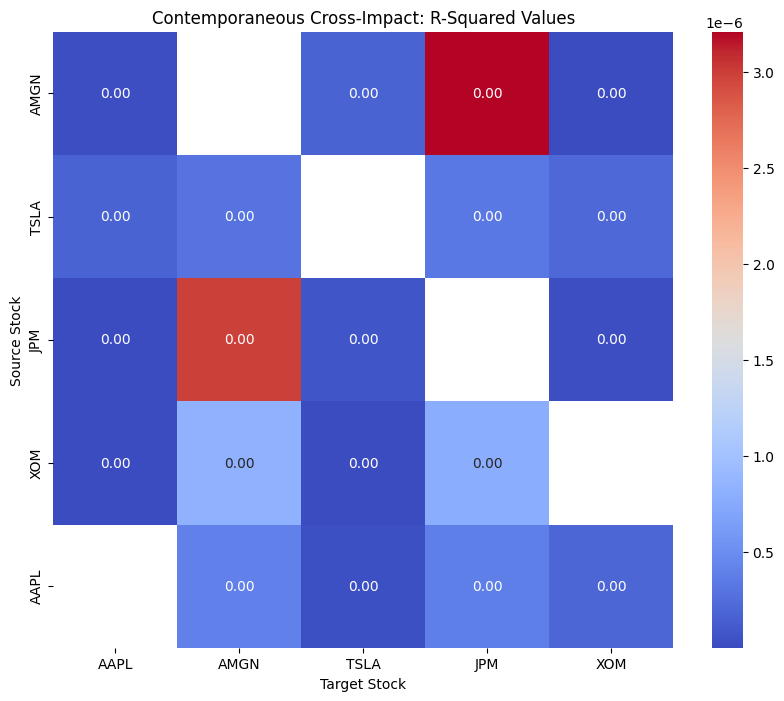

In [21]:
contemporaneous_df = pd.DataFrame(contemporaneous_results)
plt.figure(figsize=(10, 8))
sns.heatmap(contemporaneous_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Contemporaneous Cross-Impact: R-Squared Values")
plt.xlabel("Target Stock")
plt.ylabel("Source Stock")
plt.savefig(f"{results_path}/contemporaneous_cross_impact.png")
plt.show()

Highest correlation between AMGN (healthcare) and JPM (financial).

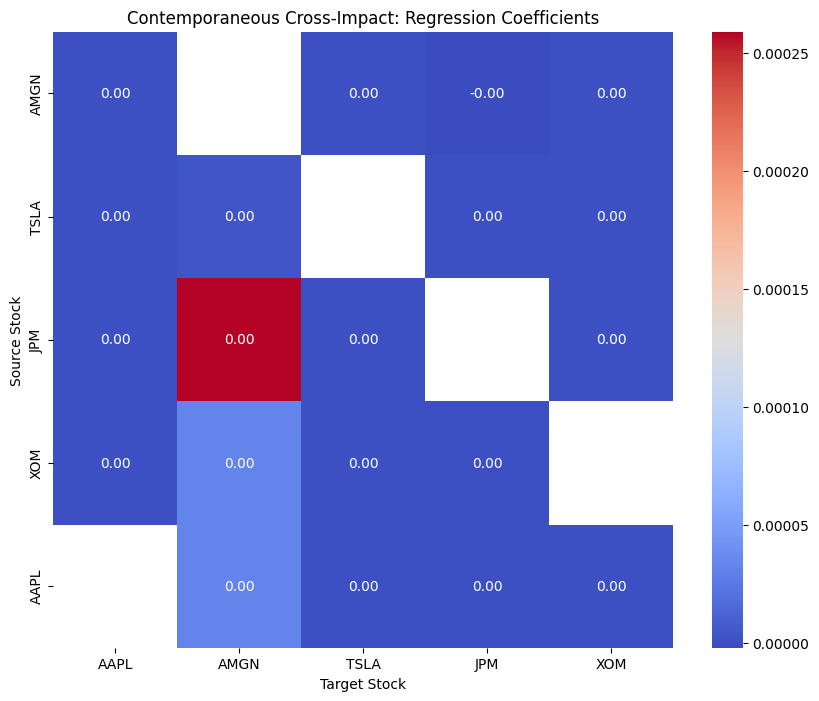

In [25]:
coeff_df = pd.DataFrame(coeff_results)
plt.figure(figsize=(10, 8))
sns.heatmap(coeff_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Contemporaneous Cross-Impact: Regression Coefficients")
plt.xlabel("Target Stock")
plt.ylabel("Source Stock")
plt.savefig(f"{results_path}/contemporaneous_coefficients.png")
plt.show()

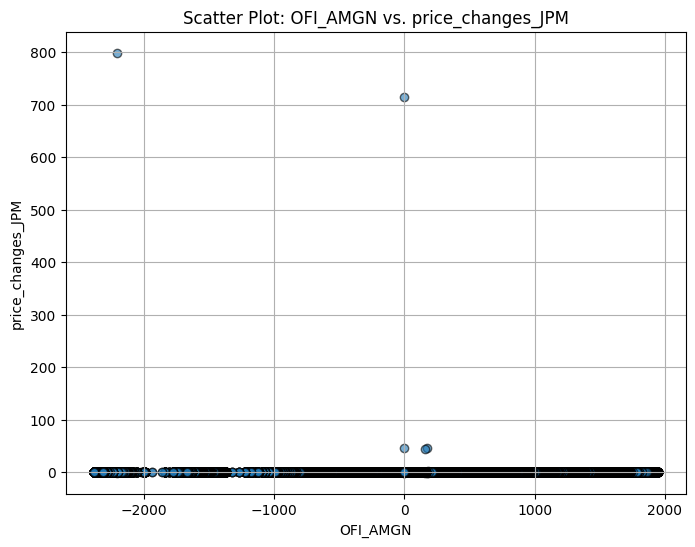

In [27]:
source_stock = "AMGN"
target_stock = "JPM"
plt.figure(figsize=(8, 6))
plt.scatter(
    analysis_data_df[f"pca_ofi_{source_stock}"], 
    analysis_data_df[f"price_changes_{target_stock}"], 
    alpha=0.6, edgecolor='k'
)
plt.title(f"Scatter Plot: OFI_{source_stock} vs. price_changes_{target_stock}")
plt.xlabel(f"OFI_{source_stock}")
plt.ylabel(f"price_changes_{target_stock}")
plt.grid(True)
plt.savefig(f"{results_path}/scatter_{source_stock}_to_{target_stock}.png")
plt.show()

Understand the directional flow of influence.

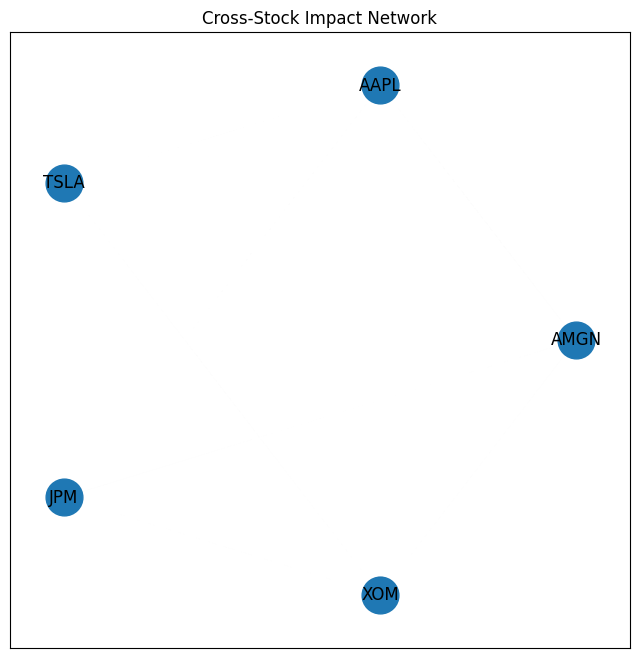

In [15]:
G = nx.DiGraph()

for target in stocks:
    for source in stocks:
        if source != target:
            G.add_edge(source, target, weight=coeff_results[target][source])

plt.figure(figsize=(8, 8))
pos = nx.circular_layout(G)
edges = G.edges(data=True)

nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(
    G, pos, edgelist=edges, 
    width=[edge[2]['weight']*5 for edge in edges], 
    arrowstyle="-|>", arrowsize=10
)
nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")

plt.title("Cross-Stock Impact Network")
plt.savefig(f"{results_path}/cross_stock_impact_network.png")
plt.show()

### Evaluate the predictive power of lagged cross-asset OFI on future price changes

In [17]:
lag_intervals = [1, 5]

for stock in stocks:
    for lag in lag_intervals:
        analysis_data_df[f"pca_ofi_{stock}_lag{lag}"] = analysis_data_df[f"pca_ofi_{stock}"].shift(lag)

lagged_results = {}

for target_stock in stocks:
    lagged_results[target_stock] = {}
    for source_stock in stocks:
        if source_stock == target_stock:
            continue

        X, y = prepare_lagged_data(source_stock, target_stock, lag_intervals, analysis_data_df)
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        lagged_results[target_stock][source_stock] = r2

Strongest correlation between JPM (financials) and AMGN (tech).

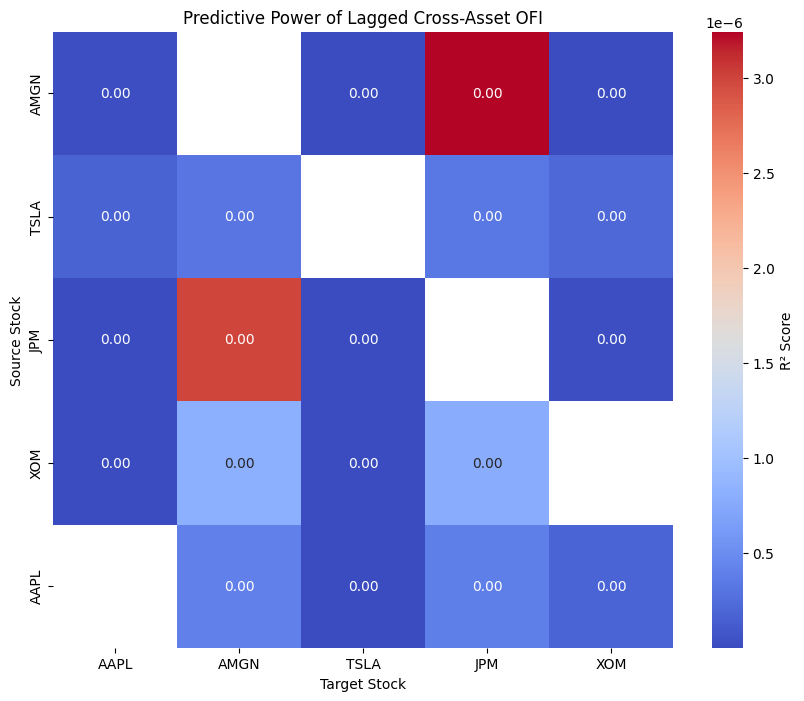

In [18]:
lagged_r2_df = pd.DataFrame(lagged_results)

plt.figure(figsize=(10, 8))
sns.heatmap(lagged_r2_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "R² Score"})
plt.title("Predictive Power of Lagged Cross-Asset OFI")
plt.xlabel("Target Stock")
plt.ylabel("Source Stock")
plt.savefig(f"{results_path}/lagged_ofi_predictive_power_heatmap.png")
plt.show()

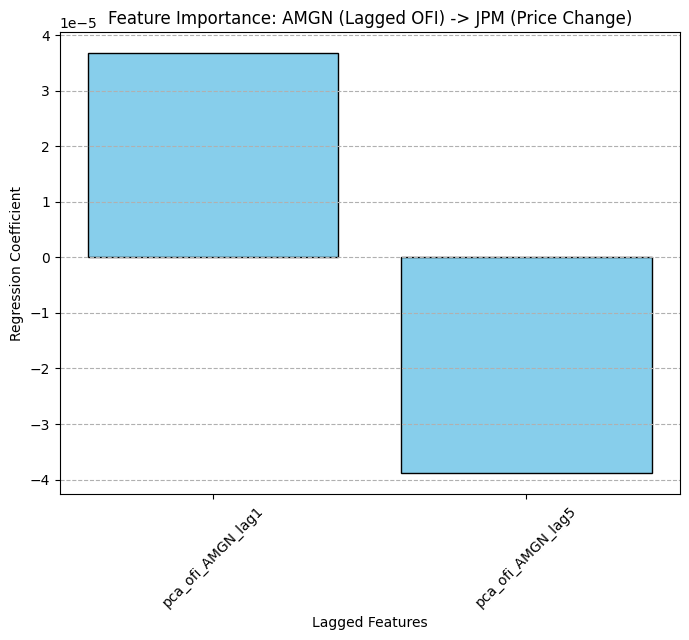

In [21]:
source_stock = "AMGN"
target_stock = "JPM"
X, y = prepare_lagged_data(source_stock, target_stock, lag_intervals, analysis_data_df)
model = LinearRegression().fit(X, y)

plt.figure(figsize=(8, 6))
plt.bar(X.columns, model.coef_, color="skyblue", edgecolor="black")
plt.title(f"Feature Importance: {source_stock} (Lagged OFI) -> {target_stock} (Price Change)")
plt.xlabel("Lagged Features")
plt.ylabel("Regression Coefficient")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--")
plt.savefig(f"{results_path}/feature_importance_{source_stock}_to_{target_stock}.png")
plt.show()

High R-squared values indicate strong predictive power.
Self-impact is often stronger than cross-impact but may depend on market conditions.

## 